# Code with clear comments for BIRCH Implementation

### Run all cells and see the results at the end of last cell

In [1]:
# to import all basic and necessary libraries
import numpy as np
import pandas as pd
from scipy.io import arff
from matplotlib import pyplot as plt
# to show a grid for matplotlib scatter plots
# only to make it visually more appealing
import seaborn as sns
sns.set()

In [2]:
# to Set array dtype as float64 to fit the data as is
def set_array_dtype(array):
    dtype = np.float64
    array = np.asarray(array, dtype=dtype)
    return array

In [3]:
# Generator to create slices containing batch_size elements, from 0 to n
# The last slice may contain less than batch_size elements, when batch_size does not divide n
def gen_batches(n, batch_size):
    start = 0

    # we just need to iterate so index is not required here and so we use _
    for _ in range(int(n // batch_size)):
        end = start + batch_size
        if end > n:
            continue
        yield slice(start, end)
        start = end
    if start < n:
        yield slice(start, n)


In [4]:
# to generate a distance matrix chunk by chunk
# yields D_chunk which is an array or a contiguous slice of distance matrix
def pairwise_distances_chunked(X, Y=None, **kwds):
    n_samples_X = X.shape[0]
    chunk_n_rows = int(1024 * (2 ** 20) // (8 * Y.shape[0]))
    chunk_n_rows = min(chunk_n_rows, n_samples_X)

    slices = gen_batches(n_samples_X, chunk_n_rows)

    for sl in slices:
        if sl.start == 0 and sl.stop == n_samples_X:
            X_chunk = X  # to enable optimised paths for X is Y
        else:
            X_chunk = X[sl]
        D_chunk = euclidean_distances(X_chunk, Y, **kwds)
        indices = D_chunk.argmin(axis=1)
        values = D_chunk[np.arange(D_chunk.shape[0]), indices]
        D_chunk = indices, values
        yield D_chunk

In [5]:
# To compute minimum distances between one point and a set of points
# This function computes for each row in X, the index of the row of Y which is closest (according to the specified distance)
# The minimal distances are also returned
def pairwise_distances(X, Y, *, metric_kwargs={}):
    X = set_array_dtype(X)
    Y = set_array_dtype(Y)

    indices, values = zip(*pairwise_distances_chunked(X, Y, **metric_kwargs))
    indices = np.concatenate(indices)
    values = np.concatenate(values)

    return indices, values

In [6]:
# to calculate  euclidean distances between X and Y or between X and itself if Y is None
def euclidean_distances(X, Y=None, Y_norm_squared=None):
    XX = np.einsum('ij,ij->i', X, X)[:, np.newaxis]
    if Y_norm_squared is not None:
        YY = np.atleast_2d(Y_norm_squared)
    else:
        YY = np.einsum('ij,ij->i', Y, Y)[:, np.newaxis]
    if Y is None:
        distances = - 2 * (X @ X.T)
    else:
        distances = - 2 * (X @ Y.T)
    distances += XX
    distances += YY
    np.maximum(distances, 0, out=distances)
    return distances

In [7]:
# the node has to be split if there is no place for a new subcluster in the node
def splitNode(node, threshold, branching_factor):
    # create two new subclusters and two new nodes of Cluster Frequency (CF)
    # also set these two CF nodes as children to corresponding SCs (SubClusters)
    sc1 = SubCluster_CF()
    n1 = Node_CF(threshold, branching_factor, node.leafNode_flag, node.n_features)
    sc1.childNode = n1

    sc2 = SubCluster_CF()
    n2 = Node_CF(threshold, branching_factor, node.leafNode_flag, node.n_features)
    sc2.childNode = n2

    # the pair of distant subclusters are found
    if node.leafNode_flag:

        # arrange the DLL (Doubly Linked List) of leaf nodes in accordance with split
        n1.Prev_LeafNode = node.Prev_LeafNode
        n2.Prev_LeafNode = n1
        n2.Next_LeafNode = node.Next_LeafNode
        n1.Next_LeafNode = n2

        if node.Prev_LeafNode is not None:
            node.Prev_LeafNode.Next_LeafNode = n1

        if node.Next_LeafNode is not None:
            node.Next_LeafNode.Prev_LeafNode = n2

    # the properties of the empty subclusters and nodes are updated
    # according to the nearest distance between the subclusters to the pair of distant subclusters
    dist = euclidean_distances(node.centroids, Y_norm_squared=node.squared_norm)

    node1_dist, node2_dist = dist[(np.unravel_index(dist.argmax(), (dist.shape[0], dist.shape[0])),)]

    node1_closer = node1_dist < node2_dist

    # the two nodes are set as children to the two subclusters.
    for ind, subcluster in enumerate(node.subclusters):
        n1.append_subcluster(subcluster) if node1_closer[ind] else n2.append_subcluster(subcluster)
        sc1.update(subcluster) if node1_closer[ind] else sc2.update(subcluster)

    return sc1, sc2

In [8]:
# as we know each node in a CFTree is called a CFNode. this is a class for the same
# note that the CFNode can have a maximum of branching_factor number of CFSubclusters.
class Node_CF:

    def __init__(self, threshold, branching_factor, leafNode_flag, n_features):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_features = n_features
        self.init_centroids = np.zeros((branching_factor + 1, n_features))
        self.init_sq_norm = np.zeros((branching_factor + 1))
        self.leafNode_flag = leafNode_flag
        self.Prev_LeafNode = self.Next_LeafNode = None

        # initialize lists of subclusters, centroids and squared norms to manipulate throughout
        self.subclusters = self.squared_norm = []

    def append_subcluster(self, subcluster):
        # add this subcluster(SC) into the subcluster list (of this class)
        self.subclusters.append(subcluster)

        # dont include the just added SC in the n_samples count
        self.init_centroids[len(self.subclusters) - 1] = subcluster.centroid
        n_samples_with_SC = len(self.subclusters)

        # we keep centroids and squared norm as views
        # as in this way if we change init_centroids and init_sq_norm which is sufficient
        self.centroids = self.init_centroids[:n_samples_with_SC, :]
        n_samples = len(self.subclusters) - 1
        self.init_sq_norm[n_samples] = subcluster.squared_norm
        self.squared_norm = self.init_sq_norm[:n_samples_with_SC]

    # to retrieve the index of a subcluster from the list of subclusters
    def get_SC_Index(self, subcluster):
        ind = self.subclusters.index(subcluster)
        return ind

    # to remove a subcluster from a node and update it with the split subclusters.
    def update_split_subclusters(self, subcluster, new_subcluster1, new_subcluster2):
        corresponding_index = self.get_SC_Index(subcluster=subcluster)
        self.append_subcluster(new_subcluster2)
        self.subclusters[corresponding_index] = new_subcluster1
        self.init_centroids[corresponding_index] = new_subcluster1.centroid
        self.init_sq_norm[corresponding_index] = new_subcluster1.squared_norm

    # to insert a new subcluster into the node.
    def insert_cf_subcluster(self, subcluster):

        # We need to find the closest subcluster among all the
        # subclusters so that we can insert our new subcluster.
        threshold = self.threshold
        branching_factor = self.branching_factor

        # we return false when self.subclusters is empty after appending the SC to subclusters list
        if not self.subclusters:
            self.append_subcluster(subcluster)
            return False

        dist_matrix = (-2. * np.dot(self.centroids, subcluster.centroid)) + self.squared_norm

        # this closest index can be either a single int or a list of int
        # being list or a single int depends on dataset
        closest_index = np.argmin(dist_matrix)

        # Eg. : for Birch Dataset in artificial folder it is a list
        closest_subcluster = self.subclusters[closest_index]

        # If the subcluster has a child, we need a recursive strategy
        # else its straightforward - merged indexing strategy
        if closest_subcluster.childNode is None:
            SCs_length = len(self.subclusters)
            b_factor = self.branching_factor
            merged = closest_subcluster.merge_subcluster(subcluster, self.threshold)
            # not close to any other subclusters, and we still have space, so add.
            if merged:
                self.init_centroids[closest_index] = closest_subcluster.centroid
                self.init_sq_norm[closest_index] = closest_subcluster.squared_norm
                return False

            self.append_subcluster(subcluster)
            # We do not have enough space nor is it closer to an other subcluster. Hence we need to split.
            return False if SCs_length < b_factor else True

        else:

            split_child = closest_subcluster.childNode.insert_cf_subcluster(subcluster)

            # it means things not too good. we need to redistribute the subclusters in our child node
            # Also add a new subcluster in the parent subcluster to accommodate the new child.
            if split_child:
                new_subcluster1, new_subcluster2 = splitNode(closest_subcluster.childNode, threshold,
                                                             branching_factor)
                self.update_split_subclusters(closest_subcluster, new_subcluster1, new_subcluster2)

                return True if len(self.subclusters) > self.branching_factor else False

            # If it is determined that the child need not be split, we can just update the closest_subcluster
            else:
                closest_subcluster.update(subcluster)
                self.init_centroids[closest_index] = self.subclusters[closest_index].centroid
                self.init_sq_norm[closest_index] = self.subclusters[closest_index].squared_norm
                return False

In [9]:
# each subcluster in a CFNode is called a CFSubcluster, and this is a class to generalize the same
class SubCluster_CF:
    def __init__(self, *, linear_sum=None):
        self.n_samples = 0 if linear_sum is None else 1
        if linear_sum is None:
            self.linear_sum = 0
        else:
            self.linear_sum = linear_sum
        self.centroid = linear_sum
        self.sum_squared = 0.0 if linear_sum is None else np.dot(self.linear_sum, self.linear_sum)
        if self.sum_squared != 0.0:
            self.squared_norm = self.sum_squared

        self.childNode = None

    # to update all the variables(declared above in the constructor) in accordance to data fed
    def update(self, subcluster):

        self.linear_sum += subcluster.linear_sum
        self.n_samples += subcluster.n_samples
        self.centroid = self.linear_sum / self.n_samples
        self.squared_norm = np.dot(self.centroid, self.centroid)
        self.sum_squared += subcluster.sum_squared

    # to check if a cluster is worthy enough to be merged and merge it is so
    def merge_subcluster(self, nominee_cluster, threshold):
        new_ls = self.linear_sum + nominee_cluster.linear_sum
        new_n = self.n_samples + nominee_cluster.n_samples

        # dot product of new centroids
        new_norm = np.dot((1 / new_n) * new_ls, (1 / new_n) * new_ls)
        new_ss = self.sum_squared + nominee_cluster.sum_squared

        # comparing the sq_radius(obtained from the above new_ attributes) with threshold(squared as well)
        if (new_ss + (-2 * new_n) * new_norm) / new_n + new_norm <= threshold ** 2:
            (self.n_samples, self.linear_sum, self.sum_squared, self.centroid,
             self.squared_norm) = new_n, new_ls, new_ss, (1 / new_n) * new_ls, new_norm
            return True
        return False

In [10]:
# this is the main class which implements the BIRCH algorithm
# in the process we make use of above classes and their methods, variables
class Algorithm:
    def __init__(self, threshold=0.5, branching_factor=50):
        self.threshold = threshold
        self.branching_factor = branching_factor

    # to build Cluster Frequency(CF) Tree based on the data fed
    def buildCFTree(self, X):
        X = set_array_dtype(X)

        threshold = self.threshold
        branching_factor = self.branching_factor
        n_samples, n_features = X.shape

        self.RootNode = Node_CF(threshold, branching_factor, True, n_features)
        self.TempLeaf = Node_CF(threshold, branching_factor, True, n_features)
        self.TempLeaf.Next_LeafNode = self.RootNode
        self.RootNode.Prev_LeafNode = self.TempLeaf

        for sample in iter(X):
            subcluster = SubCluster_CF(linear_sum=sample)

            # Check whether we need to split or not using
            # incase we need to split, we proceed doing so as below
            if self.RootNode.insert_cf_subcluster(subcluster):
                # Create two new Subclusters as per split function and remove the existing RootNode
                new_sc1, new_sc2 = splitNode(self.RootNode, threshold, branching_factor)
                del self.RootNode

                # Create a new RootNode and append the newly generated SCs
                self.RootNode = Node_CF(threshold, branching_factor, False, n_features)
                self.RootNode.append_subcluster(new_sc1)
                self.RootNode.append_subcluster(new_sc2)

        self.subcluster_centers = np.concatenate([leaf.centroids for leaf in self.obtain_leafnodes()])
        
        # to display the centriods of final subclusters
        print("\n**RESULTS AFTER RUNNING BIRCH ALGORITHM ON DATASET FED**\n")
        print("\n\nLIST OF CENTRIODS OF FINAL SUBCLUSTERS IN LEAFNODES\n\n")
        
        # to print the centriods of final subclusters
        # these centroid points itself form reduced dataset required from BIRCH algorithm
        print(self.subcluster_centers,"\n\n")
        
        # this is for global clustering of the subclusters obtained after fitting
        self.subcluster_norms = np.einsum('ij,ij->i', self.subcluster_centers, self.subcluster_centers)
        self.subcluster_labels = np.arange(len(self.subcluster_centers))

        return self

    # A function to obtain all the leaf nodes(DLL of nodes) with help of their next pointers
    def obtain_leafnodes(self):
        lptr = self.TempLeaf.Next_LeafNode  # declare a pointer to leaf ==> leaf pointer to access a leaf later
        leaf_nodes_list = []
        while True:
            if lptr is None:
                break
            else:
                leaf_nodes_list.append(lptr)
                lptr = lptr.Next_LeafNode        
        return leaf_nodes_list

    # we take in the centroids of all the subclusters from their CF tuples
    # to predict and get labels to visualise the results
    def getLabels(self, X):
        return self.subcluster_labels[
            pairwise_distances(X, self.subcluster_centers,
                               metric_kwargs={'Y_norm_squared': self.subcluster_norms})[0]]

In [11]:
# The main function to load, preprocess data and apply implemented algorithm on it
def main():
    # load the dataset using the arff module imported from scipy
    # keep varying the files as you may wish and then run all cells
    dataset_loaded, metadata = arff.loadarff(
        open("../data/square1.arff",'rt'))

    # the loaded data is in np.ndarray format
    # so we convert it to the pandas data frame format
    X = pd.DataFrame(dataset_loaded)

    # birch-rg1,2,3 files do not have the class attribute
    # so we consider only those who have the class attribute column and ignore that as part of preprocessing step
    try:
        del X['class']
    except KeyError:
        print("*******  No class attribute for this dataset  *******\n\n")

    # to view head of the pandas Dataframe X which we will be passing to our implemented algorithm
    print("Head of X Dataframe\n\n",X.head(),"\n\n")

    # to show the plots before applying any step on the data
    # it shows the plots of data set received as is
    # tune alpha for bright or darker view of cluster points
    # edgecolor is given as blue, though can be changed as per convenience
    print("BEFORE APPLICATION OF BIRCH ALGORITHM\n")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.7, edgecolors='b')
    plt.show()

    # create an object(instantiate) of Algorithm class
    alg_object = Algorithm(1.5, 50)

    # call the function to build CFTree based on data fed
    alg_object.buildCFTree(X)

    # get the labels of sub clusters and their centroid collections to visualize
    alg_out = alg_object.getLabels(X)

    # to show the plots after applying the algorithm and receiving the labels output from it
    # tune alpha for bright or darker view of cluster points
    # edgecolor is given as blue, though can be changed as per convenience
    print("AFTER APPLICATION OF BIRCH ALGORITHM\n")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=alg_out, cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.show()

Head of X Dataframe

          a0        a1
0   9.28531  14.58790
1  12.39770   8.44890
2   8.73624  11.68030
3   9.10197  12.83270
4  12.29480   8.67373 


BEFORE APPLICATION OF BIRCH ALGORITHM



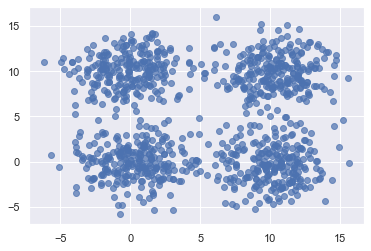


**RESULTS AFTER RUNNING BIRCH ALGORITHM ON DATASET FED**



LIST OF CENTRIODS OF FINAL SUBCLUSTERS IN LEAFNODES


[[ 9.5609307  12.08517674]
 [11.2041836  10.0521906 ]
 [ 7.90447562  9.52987219]
 [ 6.11873167 12.66275   ]
 [ 9.4087119   7.99598714]
 [12.14569375  8.03797406]
 [12.48928261 12.72245652]
 [13.74766667 10.46381583]
 [ 5.021035   10.002787  ]
 [ 6.09561    16.0267    ]
 [11.592076    3.363921  ]
 [ 8.75253385  4.42352231]
 [ 8.74615467 -1.16942003]
 [11.21130731  0.54998712]
 [ 8.59941733 -4.07142667]
 [ 7.20950857  1.19270098]
 [11.35816279 -2.57945698]
 [14.8307      5.62821   ]
 [13.61325556 -1.28239733]
 [14.9283      1.59718   ]
 [ 0.45519775  8.29162184]
 [-1.85287109 10.45847648]
 [ 0.81800269 12.63806087]
 [-2.77352842  7.61921474]
 [ 1.27195474 10.36791854]
 [-4.07534727 11.30129909]
 [-0.39282311  5.5131    ]
 [ 3.877824    6.882098  ]
 [ 1.76760657  2.1891577 ]
 [-0.71520486  0.40501183]
 [ 1.73334807 -1.04776031]
 [-1.79606869 -1.76754417]
 [-2.74440624  1.8537

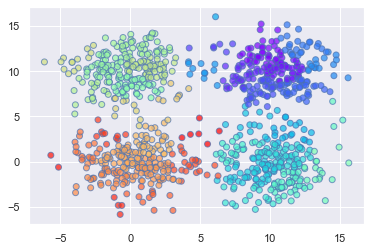

In [12]:
# to call the main function through __main__ interpretor of python
if __name__ == "__main__":
    main()